In [3]:
#load libraries
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima   


# Data Preprocessing

In [4]:
pwd

'/Users/panos/Documents/Work/aueb/students/darzanos/LoadPrediction'

In [5]:
#load folder-the actual data were given in 17 separate excel files
files = os.listdir('dataLoad')
files

['Cons_Report_122018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_072018.xlsx',
 'Load Demand_Forecast.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_012018.xlsx']

In [6]:
#list of files to loop-only xlsx
files_xls = [f for f in files if 'Cons_Report' in f]
files_xls

['Cons_Report_122018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_012018.xlsx']

In [7]:
#create one dataframe from all the excel files
actual = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('dataLoad/' + f)
    actual=actual.append(data, ignore_index=True)

In [8]:
#get column names
actual.columns

Index(['deliveryDay', 'Hour_EET', 'Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network',
       'Total'],
      dtype='object')

In [9]:
#rename columns
actual.columns=['Date','Hour','Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network','ActualTotal']
actual.head()

,Date,Hour,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,2018-12-01,1,33.006141,934.808670,0.0,954.722055,4595.257242,5563.072052
1,2018-12-01,2,43.988918,959.233194,0.0,931.364922,4063.666352,5066.888464
2,2018-12-01,3,46.329801,970.324019,0.0,910.726163,3938.994044,4955.647864
3,2018-12-01,4,36.405052,995.836951,0.0,901.447118,3755.516237,4787.758241
4,2018-12-01,5,36.149028,991.074298,0.0,896.550351,3646.883398,4674.106724


- Date,Hour=Ημερομηνια Αναφοράς
- Gen_Aux=φορτιο παραγωγής μονάδων
- HV=Φορτίο Υψηλής τάσης
- Pump=Αναμενω ενημέρωση
- Network (ΜΤ+ΧΤ)= μας δίνει το συνολικό actual φορτίο
- TEL_MV=Φορτιο της τηλεμετρουμενης μεσης τασης.
- ΧΤ= Η στηλη που δημιουργώ αφαιρώντας την τηλεμετρουμενη ΜΤ από το Network και βρίσκω την actual total XT που θέλω να προβλεψω.
- ActualTotal= Το αθροισμα των Network+HV+Gen_Aux+Pump που μας δίνει το συνολικό φορτίο. Αυτό θα το χρησιμοποιήσω αργότερα για να βρω τι ποσοστό είναι η ΧΤ σε σχέση με το ActualTotal.



In [10]:
#load excel with forecast of the current program
forecast=pd.read_excel("dataLoad/Load Demand_Forecast.xlsx")

In [11]:
forecast.head()

,Year,Month,Weekday,Holiday,Date,1,2,3,4,5,...,21,22,23,24,Sum,Avrg,Max,Min,Δ vs D-1,Δ vs D-7
0,2018,1,1,1,2018-01-01,5315.0,4963.0,4838.0,4515.0,4280.0,...,6198.0,6021.0,5756.0,5513.0,127512.0,5313.000000,6237.0,4182.0,-0.112966,-0.077077
1,2018,1,2,0,2018-01-02,5023.0,4612.0,4573.0,4389.0,4250.0,...,6831.0,6517.0,6106.0,5717.0,135940.0,5664.166667,6927.0,4250.0,0.066096,-0.011101
2,2018,1,3,0,2018-01-03,5211.0,4761.0,4721.0,4547.0,4438.0,...,7409.0,6949.0,6411.0,5962.0,146200.0,6091.666667,7554.0,4438.0,0.075474,-0.001666
3,2018,1,4,0,2018-01-04,5307.0,4788.0,4721.0,4525.0,4427.0,...,7483.0,7014.0,6476.0,6038.0,149234.0,6218.083333,7649.0,4427.0,0.020752,0.020194
4,2018,1,5,0,2018-01-05,5420.0,4932.0,4865.0,4718.0,4621.0,...,7453.0,6984.0,6455.0,6037.0,149052.0,6210.500000,7550.0,4621.0,-0.001220,0.010892


In [12]:
#data manipulation to create new dataframe
forecast2=forecast[['Weekday',  'Holiday','Date', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
prediction = pd.melt(forecast2, id_vars=["Weekday", "Holiday", "Date"])
prediction.head(10)

,Weekday,Holiday,Date,variable,value
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [13]:
prediction.tail(10)

,Weekday,Holiday,Date,variable,value
12374,3,0,2019-05-22,24,5066.0
12375,4,0,2019-05-23,24,5126.0
12376,5,0,2019-05-24,24,5092.0
12377,6,0,2019-05-25,24,4961.0
12378,7,0,2019-05-26,24,4802.0
12379,1,0,2019-05-27,24,5093.0
12380,2,0,2019-05-28,24,5088.0
12381,3,0,2019-05-29,24,5111.0
12382,4,0,2019-05-30,24,5185.0
12383,5,0,2019-05-31,24,5105.0


In [14]:
#rename columns
prediction.columns=[ 'Weekday', 'Holiday', 'Date', 'Hour', 'ForecastTotalLoad' ]
prediction.head(10)

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [15]:
#subtract one hour to get to 0-23 hour format
actual['Hour']=actual['Hour']-1
prediction['Hour']=prediction['Hour']-1

- ForecastTotalLoad είναι η προβλεψη για το συνολικό actual φορτίο όπως την κάνουν τωρα και πρέπει να συγκριθεί με την αντίστοιχη τιμή πιο πανω του ActualTotal.

In [16]:
#set index
actual.set_index(['Date', 'Hour']).head()

Gen_Aux          HV  Pump      TEL_MV      Network  \
Date       Hour                                                         
2018-12-01 0     33.006141  934.808670   0.0  954.722055  4595.257242   
           1     43.988918  959.233194   0.0  931.364922  4063.666352   
           2     46.329801  970.324019   0.0  910.726163  3938.994044   
           3     36.405052  995.836951   0.0  901.447118  3755.516237   
           4     36.149028  991.074298   0.0  896.550351  3646.883398   

                 ActualTotal  
Date       Hour               
2018-12-01 0     5563.072052  
           1     5066.888464  
           2     4955.647864  
           3     4787.758241  
           4     4674.106724

In [17]:
#set index
prediction.set_index(['Date', 'Hour']).head()

,,Weekday,Holiday,ForecastTotalLoad
Date,Hour,,,
2018-01-01,0,1,1,5315.0
2018-01-02,0,2,0,5023.0
2018-01-03,0,3,0,5211.0
2018-01-04,0,4,0,5307.0
2018-01-05,0,5,0,5420.0


* Join the two dataframes.

In [18]:
#merge datasets
final = pd.merge(prediction, actual, on=['Date', 'Hour'])
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090


In [19]:
#create Timestamp column
final['Timestamp'] = final['Date'] + pd.to_timedelta(final['Hour'], unit='h')
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985,2018-01-02
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667,2018-01-03
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647,2018-01-04
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090,2018-01-05


In [20]:
#sort by timestamp
final.sort_values('Timestamp', inplace=True)
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 00:00:00
516,1,1,2018-01-01,1,4963.0,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645,2018-01-01 01:00:00
1032,1,1,2018-01-01,2,4838.0,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316,2018-01-01 02:00:00
1548,1,1,2018-01-01,3,4515.0,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808,2018-01-01 03:00:00
2064,1,1,2018-01-01,4,4280.0,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510,2018-01-01 04:00:00


In [21]:
final.tail()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
10319,5,0,2019-05-31,19,5572.0,33.211102,876.113437,0.0,1397.706018,4901.567117,5810.891656,2019-05-31 19:00:00
10835,5,0,2019-05-31,20,5740.0,32.731239,890.764508,0.0,1355.517513,5000.305264,5923.801011,2019-05-31 20:00:00
11351,5,0,2019-05-31,21,5915.0,32.180987,861.846122,0.0,1268.293778,5123.894570,6017.921678,2019-05-31 21:00:00
11867,5,0,2019-05-31,22,5506.0,33.389455,856.024205,0.0,1152.098123,4680.730403,5570.144063,2019-05-31 22:00:00
12381,5,0,2019-05-31,23,5105.0,35.753307,964.764549,0.0,1092.041595,4227.795192,5228.313048,2019-05-31 23:00:00


In [22]:
#create the column of interest
final['XT'] = final['Network'] - final['TEL_MV']

#find the percentage of XT as to total ActualLoad for that day and Hour (TrueValues)
final['%XTofTotal']=final['XT']/final['ActualTotal']

#find the estimation of XTPrediction
final['XTForecastEstimation']=final['%XTofTotal']*final['ForecastTotalLoad']


Στο παραπάνω κελι αφού δημιουργήσω τη στηλη με τις actual τιμές της ΧΤ υπολογίζω το ποσοστό που έπιανε η ΧΤ σε σχέση με το σύνολο του φορτίου για εκείνη τη μέρα ώρα. Βρίσκοντας το ποσοστό, το εφαρμόζω μετά στην πρόβλεψη που δίνει το μοντέλο τους (το μοντέλο τους προβλέπει το σύνολικό φορτίο του δυκτίου) για να μπορέσω να προσεγγίσω την πρόβλεψη του μοντέλου αν προέβλεπε τη χαμηλή τάση. Θα το χρησιμοποιήσω στη σύγκριση μεταξυ του δικού μας και του δικού τους μοντέλου όπως είπαμε.

In [23]:
#finalize dataset and set frequency
final=final[['Timestamp','XT','Weekday','Holiday','XTForecastEstimation']]
final.sort_values('Timestamp', inplace=True)
final.set_index('Timestamp', inplace=True)

In [24]:
final

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104
2018-01-01 01:00:00,3615.862294,1,1,3584.743969
2018-01-01 02:00:00,3531.408073,1,1,3481.997027
2018-01-01 03:00:00,3250.926682,1,1,3171.205588
2018-01-01 04:00:00,3027.204711,1,1,2874.047836
2018-01-01 05:00:00,2934.418572,1,1,2624.699069
2018-01-01 06:00:00,2990.903843,1,1,2645.526199
2018-01-01 07:00:00,3048.662534,1,1,2778.846267
2018-01-01 08:00:00,3189.215049,1,1,3011.633638


* Check the index for the frequency (should be hourly).

In [25]:
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-05-31 14:00:00', '2019-05-31 15:00:00',
               '2019-05-31 16:00:00', '2019-05-31 17:00:00',
               '2019-05-31 18:00:00', '2019-05-31 19:00:00',
               '2019-05-31 20:00:00', '2019-05-31 21:00:00',
               '2019-05-31 22:00:00', '2019-05-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=12382, freq=None)

* The `None` reported value indicates that there might be missing values.

In [26]:
#check for missing values
pd.date_range(final.index.min(), final.index.max(), freq='H').difference(final.index)

DatetimeIndex(['2018-03-25 23:00:00', '2019-03-31 23:00:00'], dtype='datetime64[ns]', freq=None)

* Let's check what happens around the first date.

In [27]:
final.loc['2018-03-25':'2018-03-26']

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-03-25 00:00:00,3147.824162,7,1,3171.278635
2018-03-25 01:00:00,2740.862797,7,1,2745.225070
2018-03-25 02:00:00,2654.360886,7,1,2648.583949
2018-03-25 03:00:00,2507.887529,7,1,NaN
2018-03-25 04:00:00,2440.072651,7,1,2506.587454
2018-03-25 05:00:00,2515.380769,7,1,2532.772226
2018-03-25 06:00:00,2612.671803,7,1,2604.791065
2018-03-25 07:00:00,2930.827226,7,1,2807.819204
2018-03-25 08:00:00,3306.252447,7,1,3126.662986


* There is a missing from March 25 to March 26, 2018.

* Let's also check what is happening with the second date.

In [28]:
final.loc['2019-03-31':'2019-04-01']

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2019-03-31 00:00:00,3301.206709,7,0,3247.902346
2019-03-31 01:00:00,2873.602290,7,0,2819.229247
2019-03-31 02:00:00,2747.037509,7,0,2732.615475
2019-03-31 03:00:00,2588.609454,7,0,2603.115607
2019-03-31 04:00:00,2508.161442,7,0,2440.825764
2019-03-31 05:00:00,2584.451302,7,0,2492.355395
2019-03-31 06:00:00,2782.655535,7,0,2586.818830
2019-03-31 07:00:00,3116.754635,7,0,2827.044553
2019-03-31 08:00:00,3392.986697,7,0,3069.195420


* Same story, an hour was skipped between March 31 and April 1, 2019.

* We'll fix the issue by using the previous value.

In [29]:
#set Hourly index frequency
final = final.asfreq(freq='H', method='pad')
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-05-31 14:00:00', '2019-05-31 15:00:00',
               '2019-05-31 16:00:00', '2019-05-31 17:00:00',
               '2019-05-31 18:00:00', '2019-05-31 19:00:00',
               '2019-05-31 20:00:00', '2019-05-31 21:00:00',
               '2019-05-31 22:00:00', '2019-05-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=12384, freq='H')

In [30]:
#check again for NaN in dataframe γιατι τώρα που κουβαλάω και την επιπλέον στήλη εχω το ίδιο θέμα με την ώρα
final[final.isnull().any(axis=1)]

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-03-25 03:00:00,2507.887529,7,1,NaN


In [31]:
#NaN that day for forecastedValues
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation            NaN
Name: 2018-03-25 03:00:00, dtype: float64

In [32]:
#fill with previous value ΝαΝ
final=final.fillna(method='ffill')

In [33]:
#fixed
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation    2648.583949
Name: 2018-03-25 03:00:00, dtype: float64

# Data Exploration

In [32]:
#Here is going to be the EDA part-just some quick insights

Text(0.5, 1.0, 'Low Voltage Consumption VS Holiday')

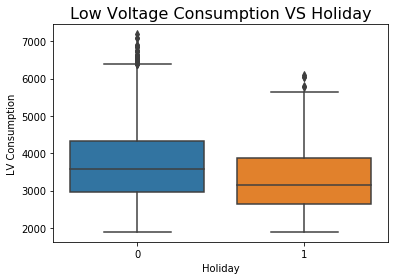

In [33]:
import seaborn as sns
sns.boxplot(x=final['Holiday'],y=final['XT']).set(ylabel='LV Consumption',xlabel='Holiday')
plt.title('Low Voltage Consumption VS Holiday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Consumption VS Weekday')

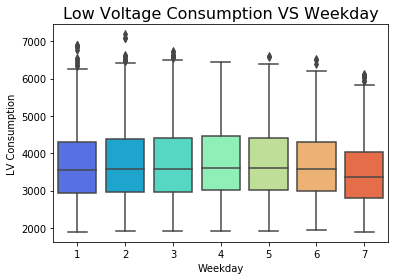

In [39]:
sns.boxplot(x=final['Weekday'],y=final['XT'],palette='rainbow').set(ylabel='LV Consumption',xlabel='Weekday')
plt.title('Low Voltage Consumption VS Weekday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Consumption')

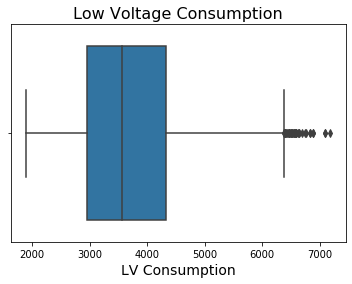

In [40]:
#there are some outliers
sns.boxplot(x=final['XT']).set_xlabel('LV Consumption',fontsize=14)
plt.title('Low Voltage Consumption',fontsize=16)


In [41]:
#check largest Values-seems logical not extreme values
print( final['XT'].nlargest(100))

Timestamp
2019-01-08 19:00:00    7187.273484
2019-01-08 18:00:00    7092.001648
2019-01-08 20:00:00    7087.291997
2019-01-07 19:00:00    6889.243639
2018-12-31 19:00:00    6886.460958
                          ...     
2019-01-07 14:00:00    6084.083217
2018-12-18 19:00:00    6070.501313
2019-02-24 19:00:00    6066.652340
2019-01-11 20:00:00    6064.160066
2018-12-19 18:00:00    6059.806308
Name: XT, Length: 100, dtype: float64


Text(0.5, 1.0, 'Daily Actual Consumption per Hour')

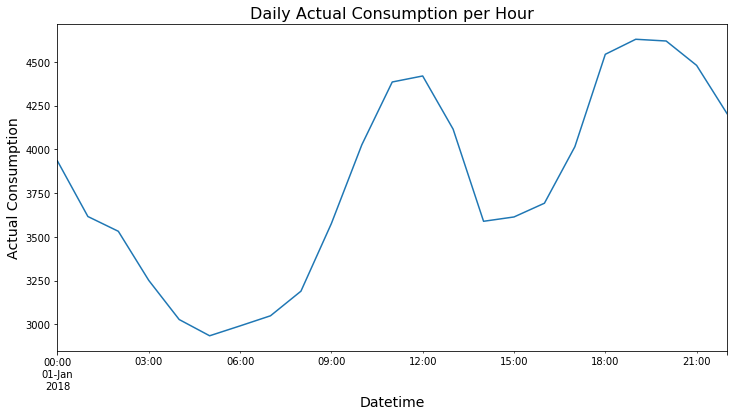

In [42]:
final['XT'].iloc[:23].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Actual Consumption', fontsize=14)
plt.title('Daily Actual Consumption per Hour', fontsize=16)

Text(0.5, 1.0, 'Actual Consumption (Historical Data)')

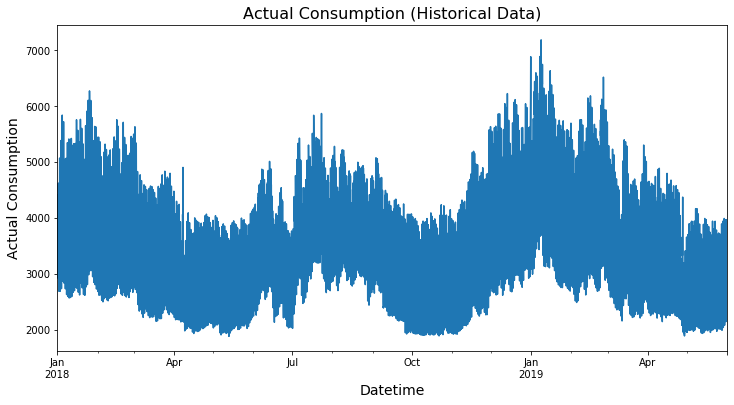

In [43]:
final['XT'].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Actual Consumption', fontsize=14)
plt.title('Actual Consumption (Historical Data)', fontsize=16)

Text(0, 0.5, 'Residual')

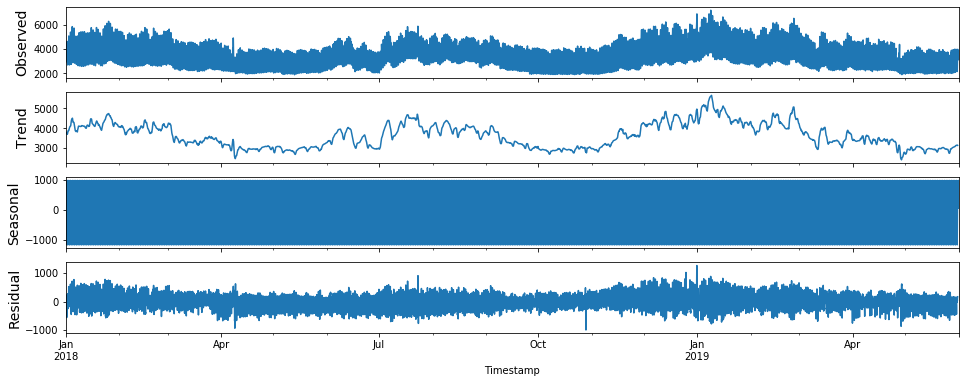

In [44]:
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(16,6))

result = seasonal_decompose(final['XT'])

result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed',fontsize=14)
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend',fontsize=14)
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal',fontsize=14)
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual',fontsize=14)


# SARIMAX

In [45]:
#create ad-fuller test function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [46]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

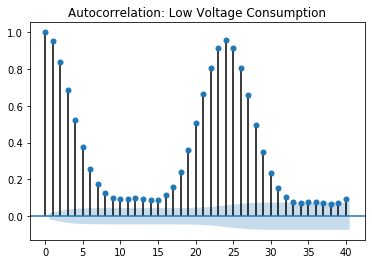

In [47]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Low Voltage Consumption'
lags = 40
plot_acf(final['XT'],title=title,lags=lags);

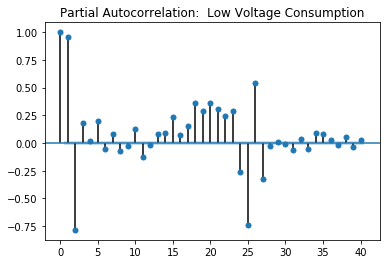

In [48]:
title='Partial Autocorrelation:  Low Voltage Consumption'
lags=40
plot_pacf(final['XT'],title=title,lags=lags);

In [49]:
#KPSS test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(series):
    print ('Results of KPSS Test:')
    kpsstest = kpss(series, regression='c', lags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [50]:
kpss_test(final['XT'])

Results of KPSS Test:
Test Statistic            1.138627
p-value                   0.010000
Lags Used                52.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [46]:
adf_test(final['XT'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.934115
p-value                     0.001798
# lags used                41.000000
# observations          12342.000000
critical value (1%)        -3.430880
critical value (5%)        -2.861774
critical value (10%)       -2.566895
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [47]:
final2=final

In [48]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(final['XT'].loc['2018-05-01':'2019-05-01'], seasonal=True, m=24).summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2) seasonal_order=(1, 0, 1, 24); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 0) seasonal_order=(2, 0, 1, 24); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pmdarima/arima/_auto_solve

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8784
Model:             SARIMAX(1, 1, 0)x(2, 0, 1, 24)   Log Likelihood              -48606.019
Date:                            Tue, 27 Aug 2019   AIC                          97224.037
Time:                                    23:14:56   BIC                          97266.521
Sample:                                         0   HQIC                         97238.511
                                           - 8784                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0150      0.059     -0.253      0.800      -0.131       0.101
ar.L1          0.5681      0.004    131.403      0.000       0.560       0.577
ar.S.L24       1.2441      0.009    144.582      0.000       1.227       1.261
ar.S.L48      -0.2443      0.009    -28.418      0.000      -0.261      -0.227
ma.S.L24      -0.7917      0.006   -129.930      0.000      -0.804      -0.780
sigma2      3696.9293     20.271    182.372      0.000    3657.198    3736.660
===================================================================================
Ljung-Box (Q):                     1762.36   Jarque-Bera (JB):             83121.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.64   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
#use the period used for training
df1=final.loc['2018-05-01':'2019-05-01']
df1.shape

(8784, 4)

* Use all data except the last two days for training and the last two days for testing.

In [52]:
#train test split
train = df1.iloc[:-24*2]
test = df1.iloc[-24*2:]

In [53]:
#run model
model = SARIMAX(train['XT'],
                exog=train[['Weekday','Holiday']],
                order=(1,1,0),
                seasonal_order=(2,0,1,24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 XT   No. Observations:                 8736
Model:             SARIMAX(1, 1, 0)x(2, 0, 1, 24)   Log Likelihood              -48337.953
Date:                            Wed, 28 Aug 2019   AIC                          96689.905
Time:                                    16:54:02   BIC                          96739.431
Sample:                                05-01-2018   HQIC                         96706.783
                                     - 04-29-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Weekday        2.6108      1.195      2.184      0.029       0.268       4.953
Holiday       27.4507      6.509      4.217      0.000      14.693      40.208
ar.L1          0.5697      0.004    130.783      0.000       0.561       0.578
ar.S.L24       1.2484      0.009    144.742      0.000       1.231       1.265
ar.S.L48      -0.2486      0.009    -28.860      0.000      -0.265      -0.232
ma.S.L24      -0.7933      0.006   -130.159      0.000      -0.805      -0.781
sigma2      3697.0447     20.317    181.972      0.000    3657.225    3736.864
===================================================================================
Ljung-Box (Q):                     1729.63   Jarque-Bera (JB):             82948.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.67   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Holiday','Weekday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, 
                              end=end, 
                              exog=exog_forecast).rename('SARIMAX(1,1,0)(2,0,1,24) Predictions')

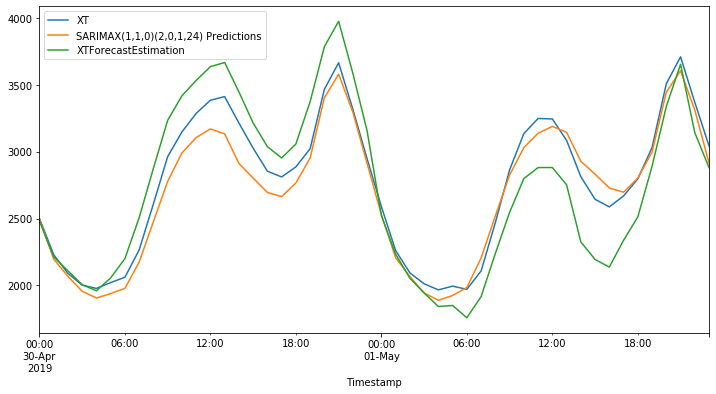

In [55]:
# Plot predictions against known values
ax = test['XT'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [56]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(test['XT'], predictions)
TheirError = rmse(final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'], test['XT'])

In [57]:
TheirError

243.02998816611498

In [58]:
#WIN??
OurError

116.87128474378312

In [59]:
#create copy of df in order to make prediction for the future
df2=final.loc['2018-05-01':'2019-05-03'].copy()

In [60]:
#set NaN to the target variable 
df2.loc['2019-05-02':'2019-05-03', 'XT'] = np.NaN

In [61]:
#retrain of full dataset
model = SARIMAX(df1['XT'],
                exog=df1[['Weekday','Holiday']],
                order=(1,1,0),
                seasonal_order=(2,0,1,24),
                enforce_invertibility=False)

In [49]:
results = model.fit()

In [50]:
#get the future data for holidays and weekday
exog_forecast = df2.iloc[len(df1):][['Holiday','Weekday']]

In [51]:
#make forcast for 2 days ahead
fcast = results.predict(len(df1),len(df1)+47,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


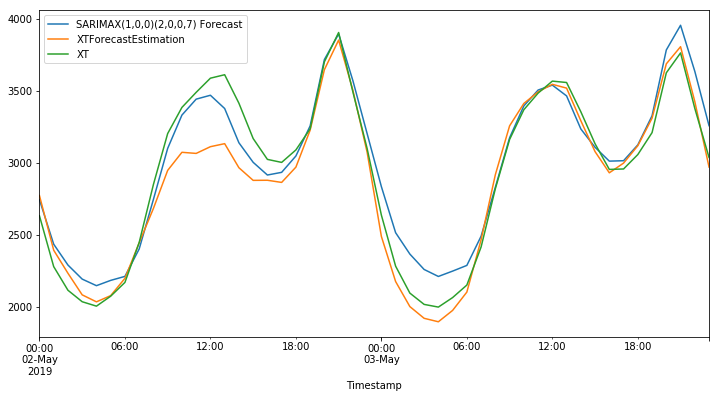

In [52]:
# Plot predictions against known values
ax = fcast.plot(legend=True,figsize=(12,6))
final['XTForecastEstimation'].loc['2019-05-02':'2019-05-03'].plot(legend=True)
final['XT'].loc['2019-05-02':'2019-05-03'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [53]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate error
OurError= rmse(final['XT'].loc['2019-05-02':'2019-05-03'], fcast)
TheirError = rmse(final['XT'].loc['2019-05-02':'2019-05-03'], final['XTForecastEstimation'].loc['2019-05-02':'2019-05-03'])

In [54]:
#WinAgain
OurError

138.20360108833202

In [55]:
#FairlyClose
TheirError

167.8694440547491

# Prophet

In [93]:
#import ProphetLibrary
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [94]:
#create holidays Dataframe for possible use by Prophet
holidays = pd.DataFrame({
    'ds': train.reset_index().query('Holiday == 1')['Timestamp'],
    'holiday': 'holiday'
})
holidays.head()

In [95]:
#fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)#, holidays=holidays)
prophet_model.fit(train['XT'].reset_index().rename(columns={'Timestamp':'ds', 'XT':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\ntarz\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [96]:
#predict
prophet_forecast = prophet_model.predict(df=test['XT'].reset_index().rename(columns={'Timestamp':'ds'}))

In [97]:
#store predictions
_ = prophet_model.plot_components(prophet_forecast)

In [ ]:
# Plot predictions against known values
fig, axes = plt.subplots(1, figsize=(16,6))
axes.plot(test.index, test['XT'], label='XT')
axes.plot(test.index, prophet_forecast['yhat'], label='Prophet', axes=axes)
final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'].plot(legend=True, axes=axes)
axes.autoscale(axis='x', tight=True)
axes.legend()

In [98]:
#calculate Error
from statsmodels.tools.eval_measures import mse,rmse
prophet_error= rmse(test['XT'], prophet_forecast['yhat'])

In [99]:
#worse
prophet_error

330.97786559210465

# RNN Keras (Univariate)

In [62]:
final2=final['XT']
final2=pd.DataFrame(final2)
final2.head()

,XT
Timestamp,
2018-01-01 00:00:00,3933.209685
2018-01-01 01:00:00,3615.862294
2018-01-01 02:00:00,3531.408073
2018-01-01 03:00:00,3250.926682
2018-01-01 04:00:00,3027.204711


In [72]:
import pandas as pd
import numpy as np
import tensorflow as tf

import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [74]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
input_data= sc.fit_transform(final2)

In [97]:
#one week
lookback = 7 * 24

test_size = len(final2) // 10
X = []
y = []
for i in range(len(final2)-lookback-1):
    t = [ [input_data[i+j, 0]] for j in range(lookback) ]
    X.append(t)
    y.append(input_data[i+ lookback])

In [106]:
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)
X_test = X[:test_size+lookback]
print(X_test.shape)

(12215, 168, 1)
(12215, 1)
(1406, 168, 1)


In [100]:
from keras import Sequential
from keras.layers import Dense, LSTM

In [99]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=300, return_sequences= True, input_shape=(X.shape[-2:])))
model.add(tf.keras.layers.LSTM(units=300, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=100))
model.add(tf.keras.layers.Dense(units=1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 168, 300)          362400    
_________________________________________________________________
lstm_9 (LSTM)                (None, 168, 300)          721200    
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,244,101
Trainable params: 1,244,101
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer='adam', loss='mean_squared_error')
history=model.fit(X, y, epochs=10, batch_size=200)

W0828 17:26:15.037882 4637054400 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
12215/12215 [==============================] - 181s 15ms/sample - loss: 0.0271
Epoch 2/10
12215/12215 [==============================] - 179s 15ms/sample - loss: 0.0085
Epoch 3/10
12215/12215 [==============================] - 186s 15ms/sample - loss: 0.0061
Epoch 4/10
12215/12215 [==============================] - 182s 15ms/sample - loss: 0.0034
Epoch 5/10
12215/12215 [==============================] - 182s 15ms/sample - loss: 0.0025
Epoch 6/10
12215/12215 [==============================] - 188s 15ms/sample - loss: 0.0023
Epoch 7/10
12215/12215 [==============================] - 179s 15ms/sample - loss: 0.0018
Epoch 8/10
12215/12215 [==============================] - 184s 15ms/sample - loss: 0.0015
Epoch 9/10
12215/12215 [==============================] - 176s 14ms/sample - loss: 0.0010
Epoch 10/10
12215/12215 [==============================] - 174s 14ms/sample - loss: 9.7114e-04


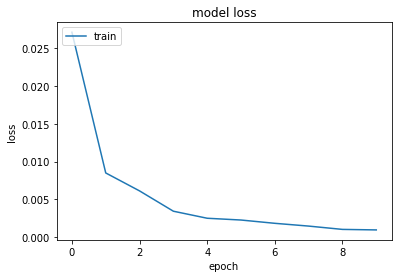

In [101]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [107]:
predicted_value = model.predict(X_test)

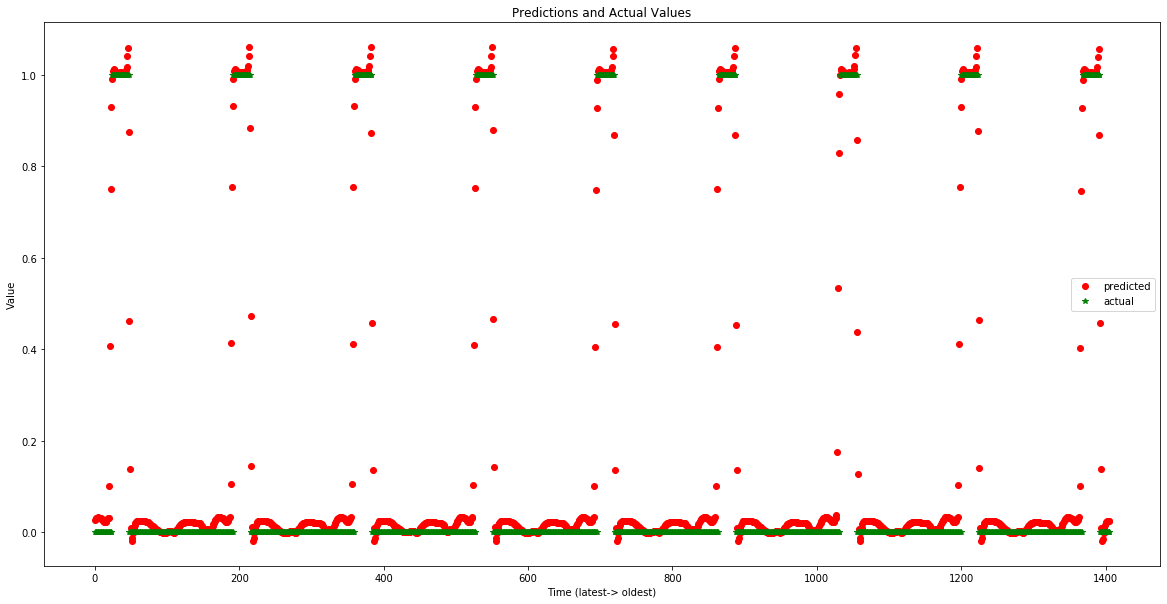

In [280]:
plt.figure(figsize=(20,10))
plt.plot(predicted_value, 'ro', label='predicted')
plt.plot(y[:test_size+lookback], 'g*', label='actual')
plt.title("Predictions and Actual Values")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Value")
plt.legend()
plt.show()

In [281]:
pred=sc.inverse_transform(predicted_value)

ValueError: non-broadcastable output operand with shape (1406,1) doesn't match the broadcast shape (1406,3)

In [112]:
actual=sc.inverse_transform(input_data[lookback:test_size+(2*lookback)])


In [113]:
from statsmodels.tools.eval_measures import mse,rmse

OurError = rmse(pred, actual)

In [114]:
OurError

array([181.71913034])

# RNN Keras (Multivariate)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [34]:
final_lstm_multi = final[['Weekday','XT','Holiday']]
final_lstm_multi = pd.DataFrame(final_lstm_multi)
final_lstm_multi.head()

,Weekday,XT,Holiday
Timestamp,,,
2018-01-01 00:00:00,1,3933.209685,1
2018-01-01 01:00:00,1,3615.862294,1
2018-01-01 02:00:00,1,3531.408073,1
2018-01-01 03:00:00,1,3250.926682,1
2018-01-01 04:00:00,1,3027.204711,1


In [35]:
final_lstm_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12384 entries, 2018-01-01 00:00:00 to 2019-05-31 23:00:00
Freq: H
Data columns (total 3 columns):
Weekday    12384 non-null int64
XT         12384 non-null float64
Holiday    12384 non-null int64
dtypes: float64(1), int64(2)
memory usage: 707.0 KB


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer([
        ("weekday", OneHotEncoder(categories='auto'), [0]),
        ("xt", MinMaxScaler(feature_range=(0,1)), [1]),
        ("holiday", "passthrough", [2])],
        sparse_threshold=0)

In [37]:
dataset = ct.fit_transform(final_lstm_multi.values)
dataset[0:100:10]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.3855027 , 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.40293079, 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.51495865, 1.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.19206572, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.441267  , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.20653378, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.513591  , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.50337793, 0.        ],


In [38]:
dataset.shape

(12384, 9)

In [39]:
TRAIN_SPLIT = dataset.shape[0] * 2 // 3
TRAIN_SPLIT

8256

In [40]:
STEP = 1 # We are going to use all samples

In [41]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, 
                      step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [57]:
past_history = 10 * 24 # 10 days in the past
future_target = 2 * 24 # two days in the future

In [58]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, -2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, -2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

* Let's check a data sample.

In [59]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('Target load to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (240, 9)
Target load to predict : (48,)


In [77]:
BATCH_SIZE = 256
BUFFER_SIZE = x_train_multi.shape[0]
BUFFER_SIZE

8016

In [61]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [84]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(16, 10))
    num_in = [ x for x in range(-int(history.shape[0]), 0, 1)]
    num_out = int(true_future.shape[0])

    plt.plot(num_in, np.array(history[:, -2]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 
             color='green',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 
                 color='brown',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

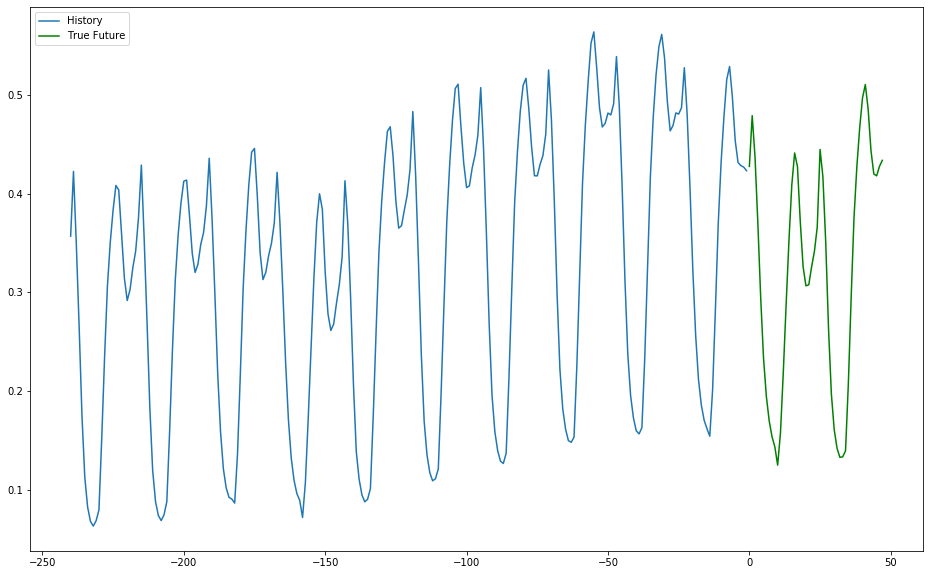

In [66]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [72]:
multivariate_model = tf.keras.models.Sequential()
multivariate_model.add(tf.keras.layers.LSTM(units=300, return_sequences=True, 
                                            input_shape=x_train_multi.shape[-2:]))
multivariate_model.add(tf.keras.layers.LSTM(units=300, return_sequences=True))
multivariate_model.add(tf.keras.layers.LSTM(units=300, return_sequences=True))
multivariate_model.add(tf.keras.layers.LSTM(units=100))
multivariate_model.add(tf.keras.layers.Dense(units=48))
multivariate_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 240, 300)          372000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 240, 300)          721200    
_________________________________________________________________
lstm_6 (LSTM)                (None, 240, 300)          721200    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 48)                4848      
Total params: 1,979,648
Trainable params: 1,979,648
Non-trainable params: 0
_________________________________________________________________


In [73]:
multivariate_model.compile(optimizer='adam', loss='mean_squared_error')

* Let's see how the model predicts before it trains.

In [74]:
for x, y in val_data_multi.take(1):
    print (multivariate_model.predict(x).shape)

(256, 48)


In [78]:
multivariate_history = multivariate_model.fit(train_data_multi, 
                                              epochs=10,
                                              steps_per_epoch=x_train_multi.shape[0] / BATCH_SIZE,
                                              validation_data=val_data_multi,
                                              validation_steps=50)

Epoch 1/10


W0904 15:27:09.867892 4517443008 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


32/31 [==============================] - 477s 15s/step - loss: 0.0359 - val_loss: 0.0269
Epoch 2/10
32/31 [==============================] - 463s 14s/step - loss: 0.0184 - val_loss: 0.0228
Epoch 3/10
32/31 [==============================] - 471s 15s/step - loss: 0.0106 - val_loss: 0.0113
Epoch 4/10
32/31 [==============================] - 495s 15s/step - loss: 0.0061 - val_loss: 0.0082
Epoch 5/10
32/31 [==============================] - 475s 15s/step - loss: 0.0044 - val_loss: 0.0069
Epoch 6/10
32/31 [==============================] - 461s 14s/step - loss: 0.0035 - val_loss: 0.0059
Epoch 7/10
32/31 [==============================] - 454s 14s/step - loss: 0.0031 - val_loss: 0.0055
Epoch 8/10
32/31 [==============================] - 460s 14s/step - loss: 0.0029 - val_loss: 0.0052
Epoch 9/10
32/31 [==============================] - 447s 14s/step - loss: 0.0027 - val_loss: 0.0046
Epoch 10/10
32/31 [==============================] - 448s 14s/step - loss: 0.0025 - val_loss: 0.0064


In [79]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

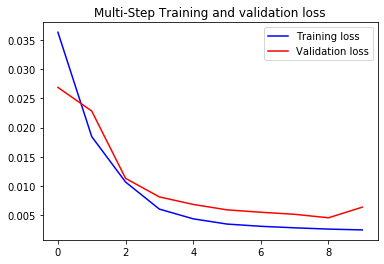

In [81]:
plot_train_history(multivariate_history, 'Multi-Step Training and validation loss')

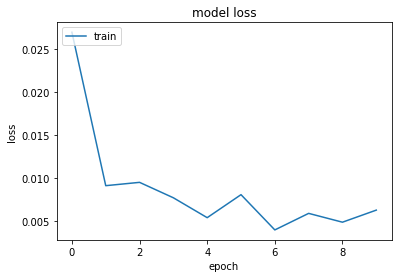

In [259]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

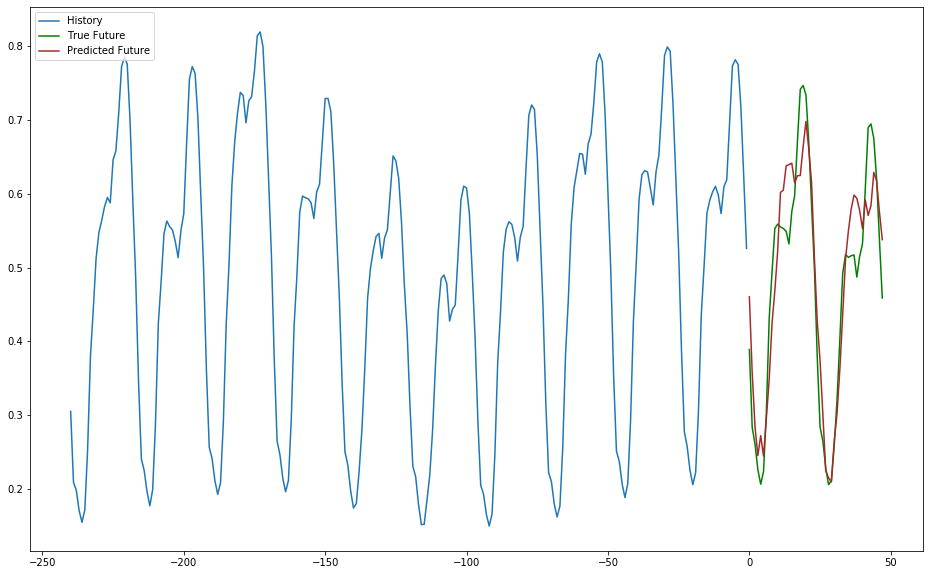

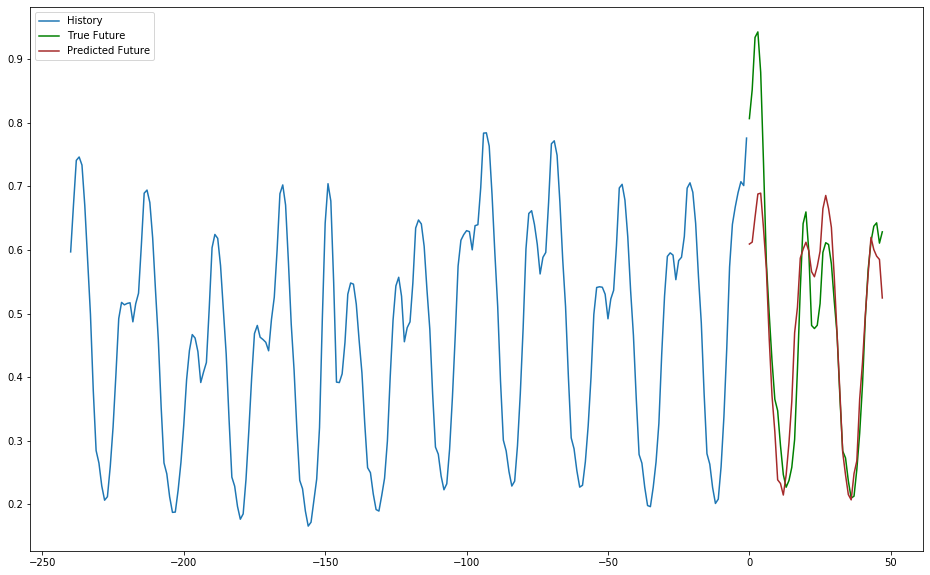

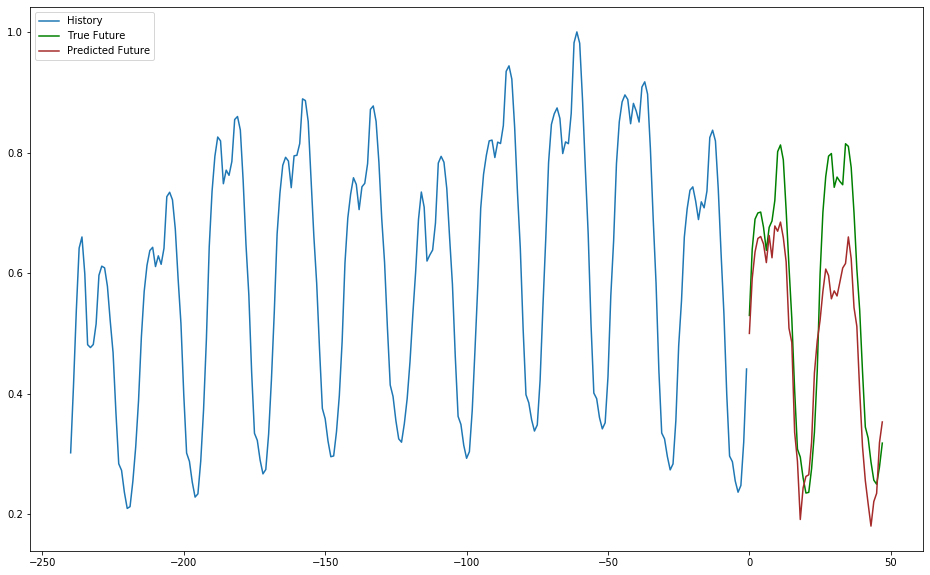

In [85]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multivariate_model.predict(x)[0])

In [75]:
#had problem in inversing the scaling because I provide 1D instead of 3D, found it on stackoverflow
# create empty table with 3 fields
trainPredict_dataset_like = np.zeros(shape=(len(predicted_value), 3) )
# put the predicted values in the right field
trainPredict_dataset_like[:,1] = predicted_value[:,0]
# inverse transform and then select the right field
trainPredict = sc.inverse_transform(trainPredict_dataset_like)[:,1]

In [85]:
act=sc.inverse_transform(input_data)[:test_size+lookback, [1]]

In [93]:
from statsmodels.tools.eval_measures import mse,rmse

OurError= rmse(trainPredict, act[:,0])

In [94]:
#How can it be larger than the univariate
OurError

405.92944972775007